Since the reference paper didn't make full use of the trapezoidal fuzzy function, we can change it to a simpler rectangular shape when performing membership computation to reduce computation. Here we use the universe discourse directly.

In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline
from time import time

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from plotly.offline import init_notebook_mode

py.sign_in('imaginationsuper', 'PQj7gXzsTJFqNKsXkWMT')
init_notebook_mode(connected=True)

In [2]:
def universe_partition(data, d1=10, d2=10):
    x_max, x_min = data.max(axis=0), data.min(axis=0)    
    std_val = data.std(axis=0)
    len_val = np.round(std_val / 10)
#     len_val = 20
#     u_max, u_min = 12600+len_val, 6600-len_val
    u_max, u_min = int(x_max+d2), int(x_min-d1) # bound of universe discourse
    u_b = np.arange(u_min, u_max, step=float(len_val)) # cutting points
    u_discourse = u_b
    return u_discourse

def set_fuzzy_numbers(u_discourse_raw):
    u_s = u_discourse_raw[:-1]
    u_e = u_discourse_raw[1:]
    u_discourse = zip(u_s, u_e)
    fuzzy_numbers = list()
    for i, u_i in enumerate(u_discourse):
        fuzzy_numbers.append(np.array([u_i[0], u_i[1]]))
    return fuzzy_numbers

In [3]:
def membership_assignment(value_time_series, fuzzy_numbers):
    membership_list = np.digitize(value_time_series, fuzzy_numbers)-1
    return membership_list.tolist()

def get_membership(value, fuzzy_numbers):
    membership_index = np.digitize([value], fuzzy_numbers)[0]-1
    return membership_index

In [4]:
def FLR(membership_time_series): # transition between consecutive observations
    transitions = list()
    for j, Aj in enumerate(membership_time_series):
        if j!=0:
            Ai = membership_time_series[j-1]
            transitions.append((Ai, Aj))
    return transitions

def FLR_weight(transitions, time_series): # compute jump frequency by FLR
    jumps = map(lambda x: x[1]-x[0], transitions) # compute jumps by transitions 
    jump_time_series = zip(jumps, time_series) # assign timestamp for each jump beta^t_p,p+k
    jump_counts = defaultdict(list) 
    for key, value in jump_time_series:
        jump_counts[key].append(value) # count jump by its timestamps
    jump_counts = {key: sum(value) for key, value in jump_counts.items()} # sum up total time for each jump
    total_count = float(sum(jump_counts.values()))
    for key, value in jump_counts.iteritems(): 
        jump_counts[key] = value / total_count # normalize jumps as weights
    return jump_counts

def FRG_weight(transitions, time_series): 
    transition_time_series = zip(transitions, time_series)
    transition_groups = map(lambda x: (x[0][0], (x[0][1], x[1])), transition_time_series) 
    transition_weights = defaultdict(list)
    for key, value in transition_groups:
        transition_weights[key].append(value) # group transitions by initial state A_i
    transition_weights = {key: dict(value) for key, value in transition_weights.items()}
    for key, value in transition_weights.iteritems():
        total_weight = float(sum(value.values()))
        value = {k: (v/total_weight) for k, v in value.items()} # normalize weight inside each group
        transition_weights[key] = value
    return transition_weights

In [5]:
# forecasting by fuzzy numbers
def fuzzy_add(A, B): # Proposition #1 (1)
    return A + B # A and B are numpy array type

def fuzzy_scale(c, A): # Proposition #1 (2)
    cA = c*A # A is numpy array type
    if c>=0:
        return cA
    else:
        return cA[::-1]

def forecast_jump(i, s, A_list):
    jumps = s.keys() # possible jumps
    m = len(A_list) # number of fuzzy numbers in model
    sA_list = list()
    sk_list = list()
    Aip_list = list()
    sA = np.array([0.0]*len(A_list[0]))
    for k in jumps:
        ip = k+i
        if (ip>=0 and ip<m): # check if index is within range
            sk_list.append(s[k])
            Aip_list.append(A_list[ip])
    sk_list = np.array(sk_list) / sum(sk_list) # normalize locally
    for i in range(sk_list.size):
        sA_list.append(fuzzy_scale(sk_list[i], Aip_list[i]))
    if len(sA_list)>0:
        for sa in sA_list:
            sA = fuzzy_add(sA, sa)
    return sA
    
def forecast_transition(i, w, A_list):
    wA = np.array([0.0]*len(A_list[0])) # default FLG relation
    if i in w.keys():
        for kj, v in w[i].iteritems():
            wA = fuzzy_add(wA, fuzzy_scale(v, A_list[kj]))
    return wA

def forecast_price(As, Aw, gamma=0.1):
    if gamma<0 or gamma>1:
        raise ValueError("gamma should be between 0.0 and 1.0 (inclusive on both ends)")     
    wAi = fuzzy_scale(1-gamma, Aw)
    if (np.sum(wAi) == 0): # no FLR observed in history
        sAi = As
    else:
        sAi = fuzzy_scale(gamma, As)
    Ai_pred = fuzzy_add(sAi, wAi)
    return np.mean(Ai_pred)

In [6]:
start_time = time()
datafile = '../data/IBEX35.csv'
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%y')
df = pd.read_csv(datafile, header=0, parse_dates=['Date'], date_parser=dateparse)

split_date = pd.datetime.strptime('2014-12-31', '%Y-%m-%d')
train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]
first_date = train_data['Date'][0] - pd.DateOffset(days=1)

option = 'Price'

In [7]:
# fit training data
train_features = train_data[option].tolist()[:-1]
train_prices = train_data[option].tolist()[1:]
fit_prices = list()
u_discourse = universe_partition(train_data[option], d1=1053, d2=912)
A_list = set_fuzzy_numbers(u_discourse)
train_data_membership_series = membership_assignment(train_data[option], fuzzy_numbers=u_discourse)
transition_FLR = FLR(train_data_membership_series)
train_data_days = train_data['Date'].apply(lambda x: x-first_date).dt.days.tolist() # convert Timedelta to numeric days
jump_weights = FLR_weight(transition_FLR, train_data_days[:len(transition_FLR)])
transition_weights = FRG_weight(transition_FLR, train_data_days[:len(transition_FLR)])
for price in train_features:
    index = get_membership(price, u_discourse)
    next_price = forecast_price(forecast_jump(index, jump_weights, A_list), forecast_transition(index, transition_weights, A_list), gamma=0.9)
    fit_prices.append(next_price)
print np.sqrt(mean_squared_error(train_prices, fit_prices))

113.873796019


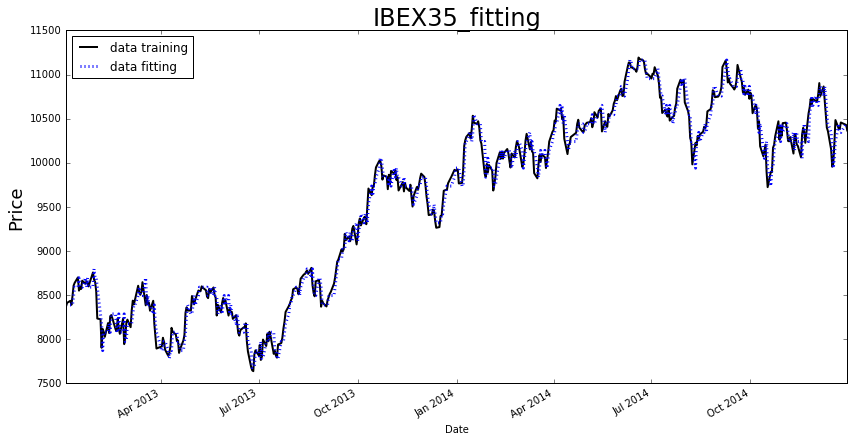

In [8]:
df_train = pd.DataFrame(train_data[1:]['Date'])
df_train['data training'] = pd.Series(train_prices).values
df_train['data fitting'] = pd.Series(fit_prices).values
df_train.index = df_train['Date']
plt.figure(figsize=(14,7))
df_train['data training'].plot(style='k-', linewidth=2, label='data training')
df_train['data fitting'].plot(style='b:', linewidth=3, label='data fitting')
plt.ylabel('Price', fontsize=18)
plt.legend(loc='best')
plt.title("IBEX35_fitting", fontsize=24)

In [9]:
# forecasting using test data
pred_prices = list()
actual_prices = test_data[option].tolist()[1:]
indices = test_data.index
for i in range(len(indices)-1):
    stm = time()
    #id = indices[i]
    prev = test_data.iloc[i]
    train_data.append(prev)
    print("Update data: %s seconds" % str(time() - stm))
    stm = time()
    u_discourse = universe_partition(train_data[option], d1=1053, d2=912)
    print("Partition discourse: %s seconds" % str(time() - stm))
    stm = time()
    A_list = set_fuzzy_numbers(u_discourse)
    print("Create fuzzy number: %s seconds" % str(time() - stm))
    stm = time()
    train_data_membership_series = membership_assignment(train_data[option], fuzzy_numbers=u_discourse)
#     train_data_ms = [ms+1 for ms in train_data_membership_series]
    print("Update fuzzy membership: %s seconds" % str(time() - stm))
    stm = time()
    transition_FLR = FLR(train_data_membership_series)
    print("Update FLR: %s seconds" % str(time() - stm))
    stm = time()
    train_data_days = train_data['Date'].apply(lambda x: x-first_date).dt.days.tolist() # convert Timedelta to numeric days
    jump_weights = FLR_weight(transition_FLR, train_data_days[:len(transition_FLR)])
    print("Update jump weights: %s seconds" % str(time() - stm))
    stm = time()
    transition_weights = FRG_weight(transition_FLR, train_data_days[:len(transition_FLR)])
    print("Update transition weights: %s seconds" % str(time() - stm))
    stm = time()
    # forecasting current test data
    price = prev[option]
    index = get_membership(price, u_discourse)
    print("Assign membership for test case: %s seconds" % str(time() - stm))
    stm = time()
    next_price = forecast_price(forecast_jump(index, jump_weights, A_list), forecast_transition(index, transition_weights, A_list), gamma=0.9)
    print("Forecast next price: %s seconds" % str(time() - stm))
    stm = time()
    pred_prices.append(next_price)
    
print "RMSE = "+str(np.sqrt(mean_squared_error(actual_prices, pred_prices)))
print "Time cost: "+str(time()-start_time)+" seconds" 

Update data: 0.00433611869812 seconds
Partition discourse: 0.000305891036987 seconds
Create fuzzy number: 0.000102043151855 seconds
Update fuzzy membership: 5.50746917725e-05 seconds
Update FLR: 0.000118017196655 seconds
Update jump weights: 0.0172529220581 seconds
Update transition weights: 0.000808954238892 seconds
Assign membership for test case: 0.000174999237061 seconds
Forecast next price: 0.00020694732666 seconds
Update data: 0.00353693962097 seconds
Partition discourse: 0.00035285949707 seconds
Create fuzzy number: 0.000112056732178 seconds
Update fuzzy membership: 6.00814819336e-05 seconds
Update FLR: 0.000116109848022 seconds
Update jump weights: 0.0186161994934 seconds
Update transition weights: 0.000396013259888 seconds
Assign membership for test case: 5.10215759277e-05 seconds
Forecast next price: 0.000133991241455 seconds
Update data: 0.00330805778503 seconds
Partition discourse: 0.000838994979858 seconds
Create fuzzy number: 0.000252962112427 seconds
Update fuzzy members

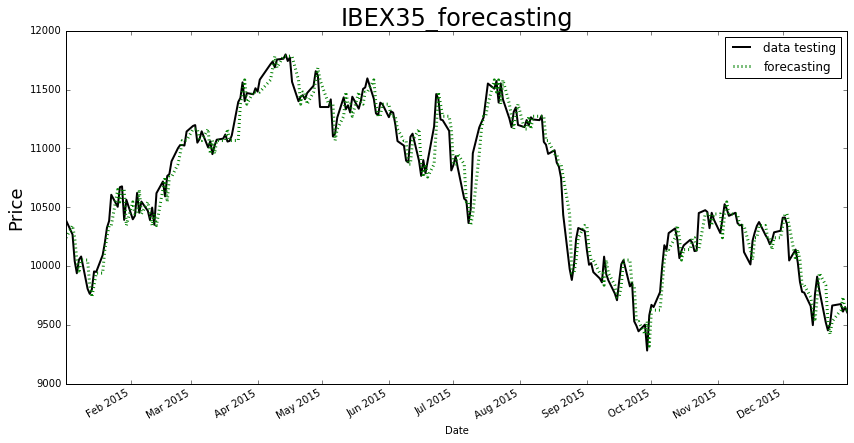

In [10]:
df_test = pd.DataFrame(test_data.iloc[1:]['Date'])
df_test['data testing'] = pd.Series(actual_prices).values
df_test['forecasting'] = pd.Series(pred_prices).values
df_test.index = df_test['Date']
plt.figure(figsize=(14,7))
df_test['data testing'].plot(style='k-', linewidth=2, label='data testing')
df_test['forecasting'].plot(style='g:', linewidth=3, label='forecasting')
plt.ylabel('Price', fontsize=18)
plt.legend(loc='best')
plt.title("IBEX35_forecasting", fontsize=24)